In [3]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Load dataset
df = pd.read_csv('Nashville_housing_data_2013_2016.csv')

# Step 1: Inspect column names
print("Column names:", df.columns.tolist())

# Step 2: Drop irrelevant columns (check first if they exist)
columns_to_drop = ['Unnamed: 0', 'Unnamed: 0.1', 'Parcel ID', 'Property Address', 
                   'Suite/ Condo   #', 'Owner Name', 'Address', 'City', 'State', 
                   'Neighborhood', 'image']

# Drop columns if they exist
df = df.drop([col for col in columns_to_drop if col in df.columns], axis=1)

# Step 3: Handle missing values

# For continuous variables, impute with median
df['Acreage'].fillna(df['Acreage'].median(), inplace=True)
df['Building Value'].fillna(df['Building Value'].median(), inplace=True)
df['Land Value'].fillna(df['Land Value'].median(), inplace=True)
df['Finished Area'].fillna(df['Finished Area'].median(), inplace=True)

# For categorical variables, impute with mode (most frequent value)
df['Foundation Type'].fillna(df['Foundation Type'].mode()[0], inplace=True)
df['Exterior Wall'].fillna(df['Exterior Wall'].mode()[0], inplace=True)
df['Grade'].fillna(df['Grade'].mode()[0], inplace=True)
df['Bedrooms'].fillna(df['Bedrooms'].mode()[0], inplace=True)
df['Full Bath'].fillna(df['Full Bath'].mode()[0], inplace=True)
df['Half Bath'].fillna(df['Half Bath'].mode()[0], inplace=True)
df['Year Built'].fillna(df['Year Built'].mode()[0], inplace=True)

# Drop rows where 'Sale Price' or 'Total Value' are missing (these are crucial columns)
df = df.dropna(subset=['Sale Price', 'Total Value'])

# Step 4: Outlier detection and removal for continuous variables

# Define a function to remove outliers using Z-score method
def remove_outliers_zscore(df, columns, threshold=3):
    z_scores = np.abs(stats.zscore(df[columns]))
    df = df[(z_scores < threshold).all(axis=1)]
    return df

# Remove outliers from critical columns
df = remove_outliers_zscore(df, ['Sale Price', 'Land Value', 'Building Value', 'Total Value'])

# Step 5: Create the target variable 'Over_Under' (whether the sale price was above or below the total value)
df['Price_Difference'] = df['Sale Price'] - df['Total Value']
df['Over_Under'] = np.where(df['Price_Difference'] > 0, 1, 0)

# Drop the now unnecessary columns
df = df.drop(['Sale Price', 'Price_Difference'], axis=1)

# Step 6: Convert categorical variables to dummy variables
df = pd.get_dummies(df, drop_first=True)

# Step 7: Normalize continuous variables using StandardScaler
scaler = StandardScaler()

# Identify continuous columns (excluding binary/encoded ones)
continuous_columns = ['Acreage', 'Land Value', 'Building Value', 'Total Value', 'Finished Area', 'Year Built']

# Scale continuous variables
df[continuous_columns] = scaler.fit_transform(df[continuous_columns])

# Step 8: Final cleaned data ready for modeling
print(f"Cleaned DataFrame shape: {df.shape}")
print(df.head())

Column names: ['Unnamed: 0', 'Unnamed: 0.1', 'Parcel ID', 'Land Use', 'Property Address', 'Suite/ Condo   #', 'Property City', 'Sale Date', 'Sale Price', 'Legal Reference', 'Sold As Vacant', 'Multiple Parcels Involved in Sale', 'Owner Name', 'Address', 'City', 'State', 'Acreage', 'Tax District', 'Neighborhood', 'image', 'Land Value', 'Building Value', 'Total Value', 'Finished Area', 'Foundation Type', 'Year Built', 'Exterior Wall', 'Grade', 'Bedrooms', 'Full Bath', 'Half Bath']
Cleaned DataFrame shape: (25132, 25553)
    Acreage  Land Value  Building Value  Total Value  Finished Area  \
1 -0.290690   -0.365665       -0.049996    -0.191493      -0.790516   
2 -0.354147   -0.336134        0.156243    -0.044775       0.370482   
3 -0.290690   -0.469020        0.913336     0.435337       0.438004   
4 -0.110896   -0.469020       -0.017386    -0.213345       0.220307   
5 -0.290690   -0.469020       -0.475696    -0.534876      -0.928580   

   Year Built  Bedrooms  Full Bath  Half Bath  Ove

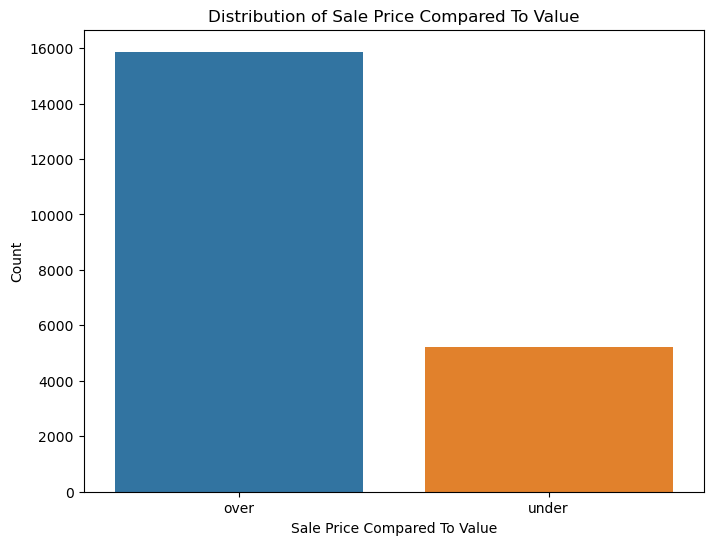

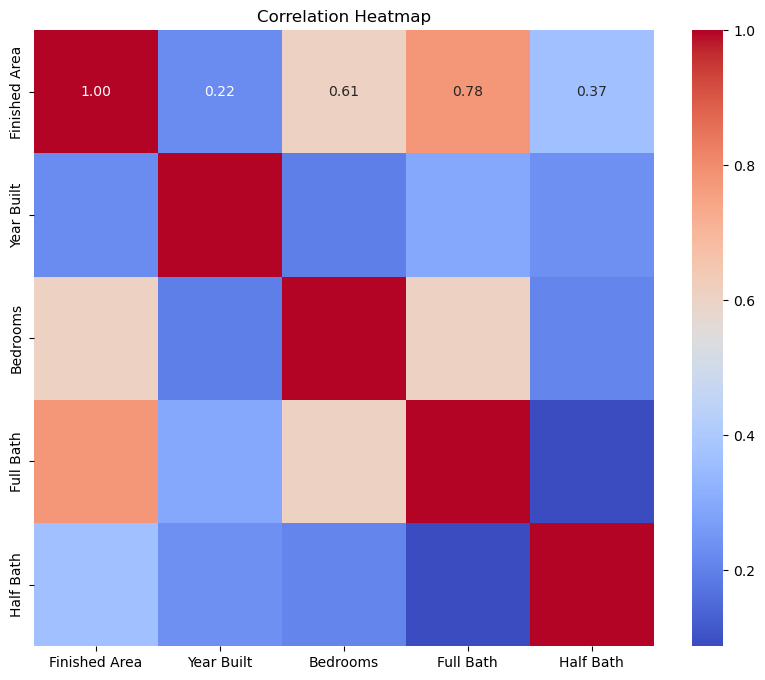

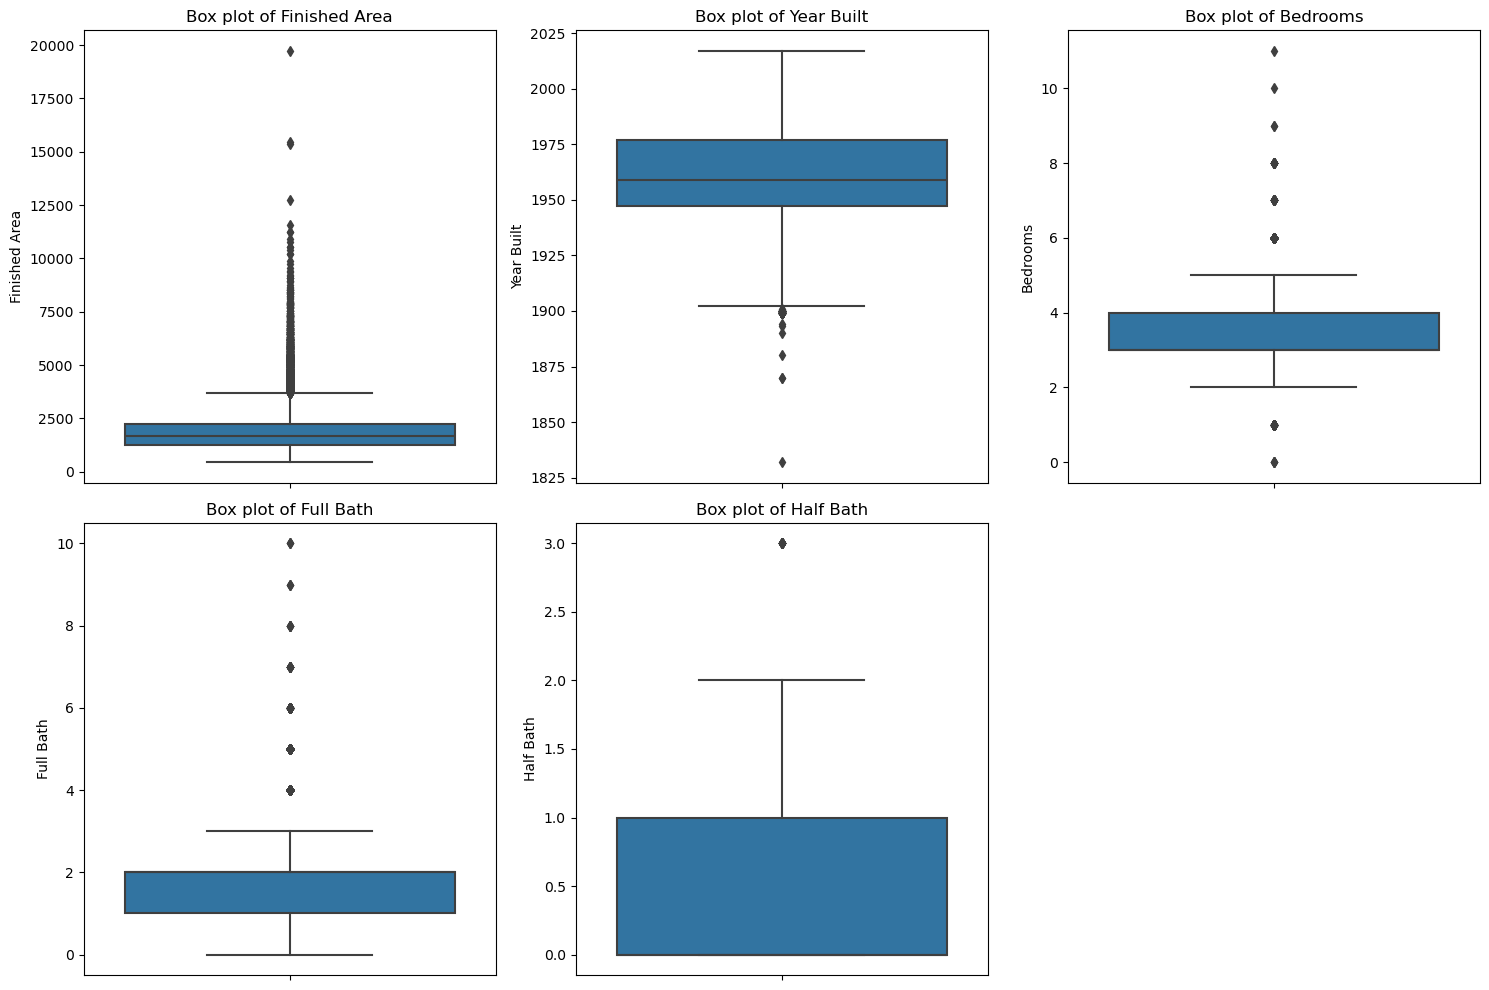

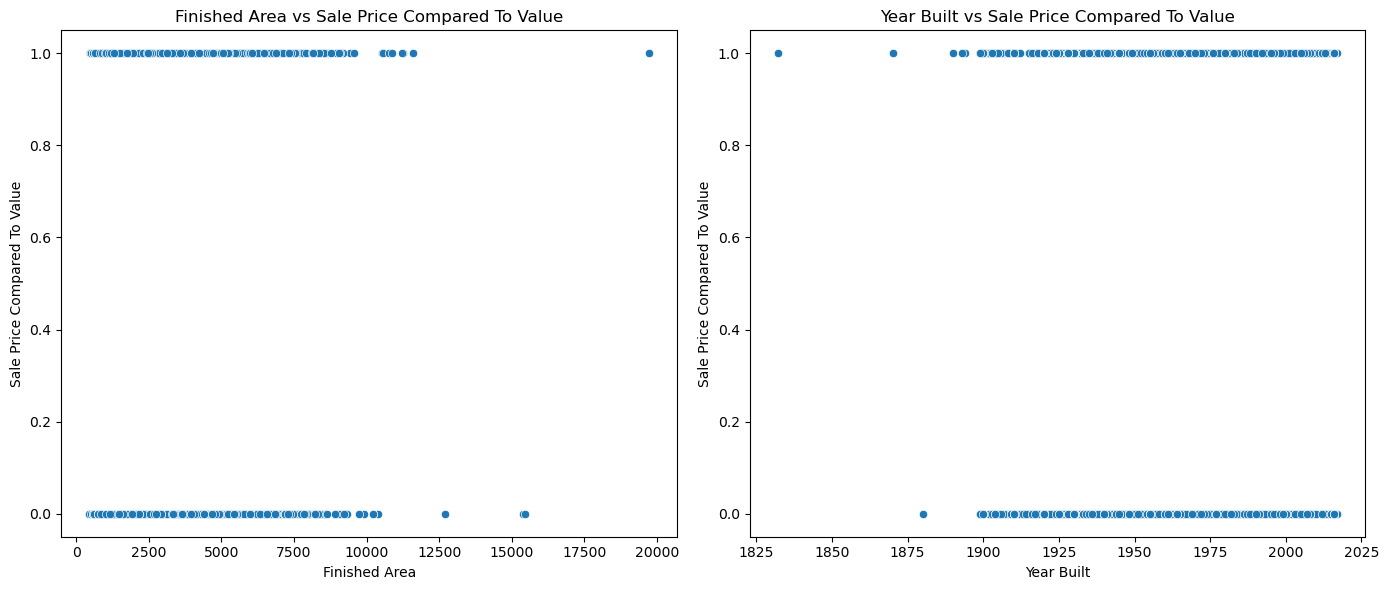

In [20]:
# Check all column names to inspect for potential issues
print(df.columns)

Index(['Acreage', 'Land Value', 'Building Value', 'Total Value',
       'Finished Area', 'Year Built', 'Bedrooms', 'Full Bath', 'Half Bath',
       'Over_Under',
       ...
       'Grade_OFB', 'Grade_OFC', 'Grade_SRC', 'Grade_SRD', 'Grade_SSC',
       'Grade_TAC', 'Grade_TCC', 'Grade_TCD', 'Grade_TFC', 'Grade_X'],
      dtype='object', length=25553)


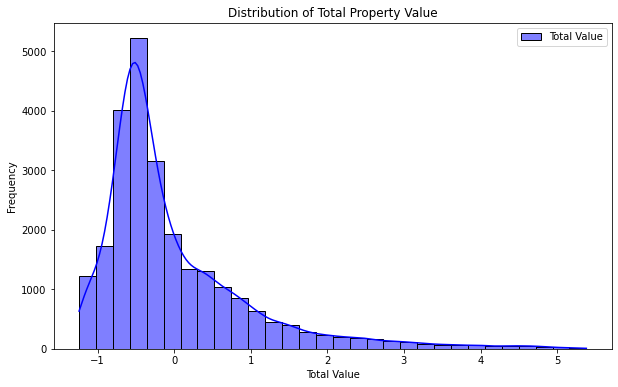

In [4]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Step 7: Visualizations

# 1. Distribution of Total Value and Sale Price
plt.figure(figsize=(10, 6))
sns.histplot(df['Total Value'], bins=30, kde=True, color='blue', label='Total Value')
plt.title('Distribution of Total Property Value')
plt.xlabel('Total Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

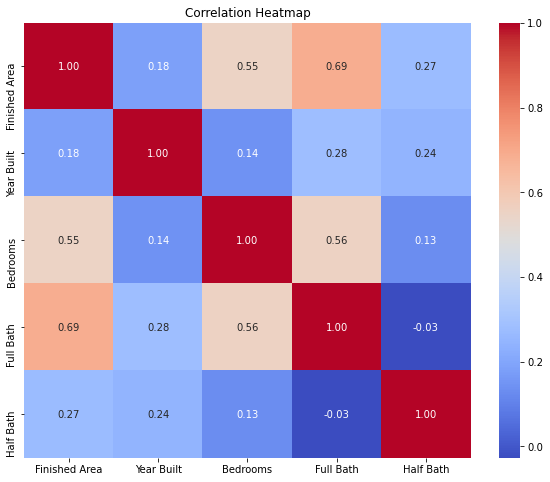

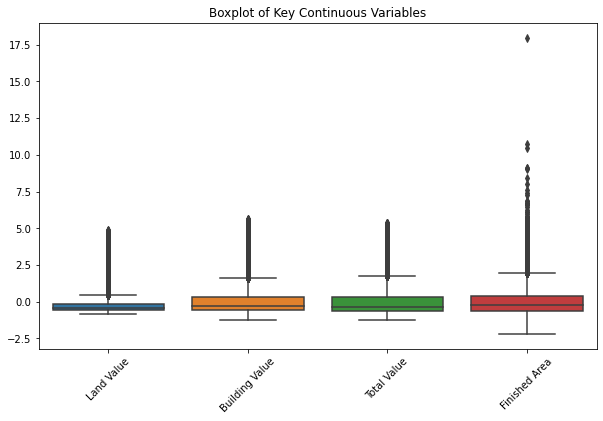

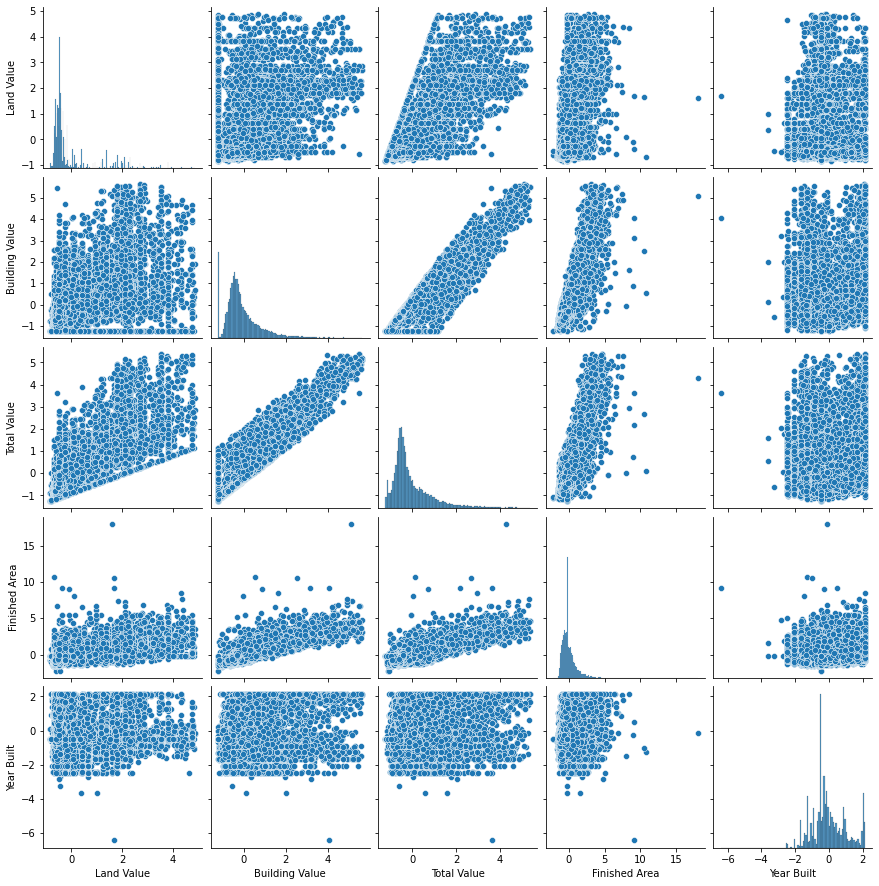

In [18]:
# Digging deeper into the data patterns

# 2. Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df[['Finished Area', 'Year Built', 'Bedrooms', 'Full Bath', 'Half Bath']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# 3. Boxplot for Continuous Variables (Detect Outliers)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Land Value', 'Building Value', 'Total Value', 'Finished Area']])
plt.title('Boxplot of Key Continuous Variables')
plt.xticks(rotation=45)
plt.show()

# 4. Pairplot for Continuous Variables
sns.pairplot(df[['Land Value', 'Building Value', 'Total Value', 'Finished Area', 'Year Built']])
plt.show()

In [21]:
#Task 2: Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define features (X) and target (y)
features = ['Acreage', 'Land Value', 'Building Value', 'Total Value',
            'Finished Area', 'Year Built', 'Bedrooms', 'Full Bath', 'Half Bath'] + \
            [col for col in df.columns if 'Grade_' in col]  # Include all encoded 'Grade' features

X = df[features]
y = df['Over_Under']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Make predictions
y_pred_logreg = logreg.predict(X_test)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.75054704595186
Confusion Matrix:
 [[  25 1226]
 [  28 3748]]
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.02      0.04      1251
           1       0.75      0.99      0.86      3776

    accuracy                           0.75      5027
   macro avg       0.61      0.51      0.45      5027
weighted avg       0.68      0.75      0.65      5027



In [22]:
#Task 3: Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Build the decision tree model
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

# Make predictions
y_pred_dtree = dtree.predict(X_test)

# Evaluate the model
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dtree))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dtree))
print("Classification Report:\n", classification_report(y_test, y_pred_dtree))

Decision Tree Accuracy: 0.6327829719514622
Confusion Matrix:
 [[ 426  825]
 [1021 2755]]
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.34      0.32      1251
           1       0.77      0.73      0.75      3776

    accuracy                           0.63      5027
   macro avg       0.53      0.54      0.53      5027
weighted avg       0.65      0.63      0.64      5027



In [23]:
# Task 4: Random Forest
from sklearn.ensemble import RandomForestClassifier

# Build the random forest model
rforest = RandomForestClassifier(n_estimators=100, random_state=42)
rforest.fit(X_train, y_train)

# Make predictions
y_pred_rforest = rforest.predict(X_test)

# Evaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rforest))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rforest))
print("Classification Report:\n", classification_report(y_test, y_pred_rforest))

Random Forest Accuracy: 0.7135468470260593
Confusion Matrix:
 [[ 192 1059]
 [ 381 3395]]
Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.15      0.21      1251
           1       0.76      0.90      0.83      3776

    accuracy                           0.71      5027
   macro avg       0.55      0.53      0.52      5027
weighted avg       0.66      0.71      0.67      5027



In [24]:
# Task 5: Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier

# Build the gradient boosting model
gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(X_train, y_train)

# Make predictions
y_pred_gbm = gbm.predict(X_test)

# Evaluate the model
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gbm))
print("Classification Report:\n", classification_report(y_test, y_pred_gbm))

Gradient Boosting Accuracy: 0.7547244877660633
Confusion Matrix:
 [[  84 1167]
 [  66 3710]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.07      0.12      1251
           1       0.76      0.98      0.86      3776

    accuracy                           0.75      5027
   macro avg       0.66      0.52      0.49      5027
weighted avg       0.71      0.75      0.67      5027



In [26]:
# Task 6: Neural Network

from sklearn.neural_network import MLPClassifier

# Build the neural network model
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

# Make predictions
y_pred_mlp = mlp.predict(X_test)

# Evaluate the model
print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))

Neural Network Accuracy: 0.7527352297592997
Confusion Matrix:
 [[  68 1183]
 [  60 3716]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.05      0.10      1251
           1       0.76      0.98      0.86      3776

    accuracy                           0.75      5027
   macro avg       0.64      0.52      0.48      5027
weighted avg       0.70      0.75      0.67      5027



In [27]:
# Task 7: Compare Models
import pandas as pd

# Compare results
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boost', 'Neural Network'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_logreg),
        accuracy_score(y_test, y_pred_dtree),
        accuracy_score(y_test, y_pred_rforest),
        accuracy_score(y_test, y_pred_gbm),
        accuracy_score(y_test, y_pred_mlp)
    ]
})

print(model_comparison)

                 Model  Accuracy
0  Logistic Regression  0.750547
1        Decision Tree  0.632783
2        Random Forest  0.713547
3       Gradient Boost  0.754724
4       Neural Network  0.752735


In [28]:
# Task 8 (Bonus): Ensemble Model with Majority Voting
from sklearn.ensemble import VotingClassifier

# Build an ensemble model using majority voting
voting_clf = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('dtree', dtree),
    ('rforest', rforest),
    ('gbm', gbm),
    ('mlp', mlp)
], voting='hard')

voting_clf.fit(X_train, y_train)

# Make predictions
y_pred_ensemble = voting_clf.predict(X_test)

# Evaluate the ensemble model
print("Ensemble Model Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ensemble))
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

Ensemble Model Accuracy: 0.7513427491545653
Confusion Matrix:
 [[  66 1185]
 [  65 3711]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.05      0.10      1251
           1       0.76      0.98      0.86      3776

    accuracy                           0.75      5027
   macro avg       0.63      0.52      0.48      5027
weighted avg       0.69      0.75      0.67      5027

